In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da
import matplotlib.colors

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/Users/bem/miniconda3/envs/unidata/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


ModuleNotFoundError: No module named 'dask'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MERRA2_dir = '/data2/willytsai/MERRA2/inst_2d_hourly/'
# os.chdir(MERRA2_dir)

In [ ]:
files = glob(MERRA2_dir+'*201[4,5]01*')
files

In [ ]:
files = glob(MERRA2_dir+'*201[4,5,6,7,8]*') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one

In [ ]:
cwv_data

In [ ]:
lon = cwv_data.lon
lat = cwv_data.lat

TQV = cwv_data.TQV

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.pcolor(lon,lat,TQV[0,:,:])
plt.xlim(30,100)
plt.colorbar()

In [ ]:
# from xmovie import Movie

# mov = Movie(TQV)
# mov.save('/data2/brian/TQV.mp4')

# Land mask 

In [89]:
land_msk = xr.open_dataset(MERRA2_dir+'/../landmask_MERRA2.nc')
lsm = land_msk.sel(lat=slice(-30,30)).lsm[0,:,:] # landmask, 30N-30S
lsm 

<xarray.DataArray 'lsm' (lat: 121, lon: 576)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -30.0 -29.5 -29.0 -28.5 -28.0 ... 28.5 29.0 29.5 30.0
    time     datetime64[ns] 1989-01-01T12:00:00
Attributes:
    standard_name:  land_binary_mask
    long_name:      Land-sea mask
    units:          (0 - 1)

In [90]:
# maskout 
TQV_land = np.copy(TQV[0,:,:]) # TQV over land only
TQV_land[lsm==0] = np.nan

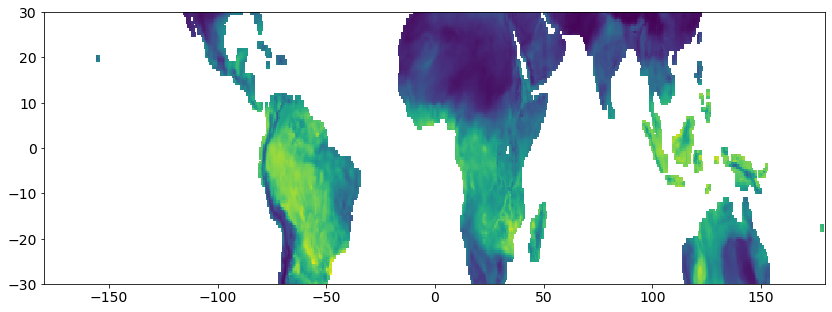

In [91]:
fig = plt.figure(figsize=(14,5))
plt.pcolor(lon,lat,TQV_land[:,:])

# Find the east coast of equatorial Africa 
### x-derivative of land mask, in 36-55 longitudes 

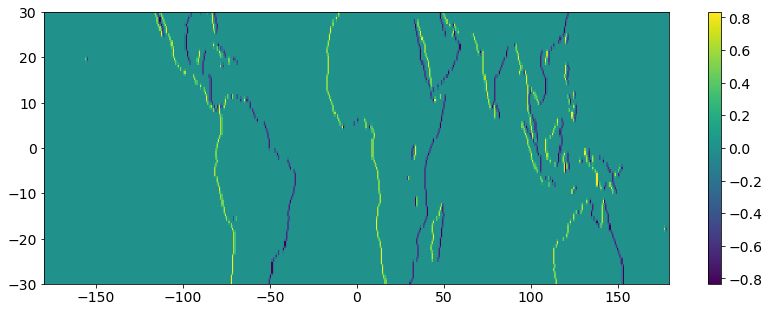

In [92]:
fig = plt.figure(figsize=(14,5))
plt.pcolor(lon,lat,lsm.diff("lon"))
plt.colorbar()

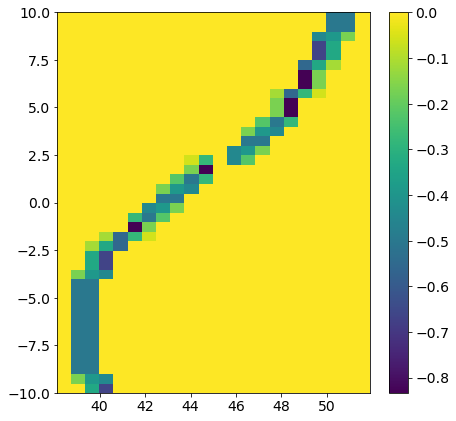

In [119]:
fig = plt.figure(figsize=(7,7))
plt.pcolor(lon.sel(lon=slice(38,52)),lat.sel(lat=slice(-10,10)), 
           lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff("lon") )
plt.colorbar()

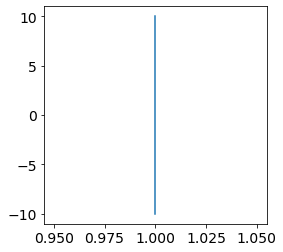

In [94]:
# Do the -diff() values add up to 1 like wieghts? Answer: yes 
maskweight = -lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff("lon")

fig = plt.figure(figsize=(4,4))
plt.plot(maskweight.sum(dim="lon"), 
          lat.sel(lat=slice(-10,10)))



# Time-latitude plot of TQV > 50 along African coast 

In [115]:
# lsm.sel(lon=slice(38,52),lat=slice(-10,10)).diff("lon") )

TQV_WEIO = (TQV.sel( lon=slice(38,52),lat=slice(-10,10) ) * maskweight).sum(dim="lon")

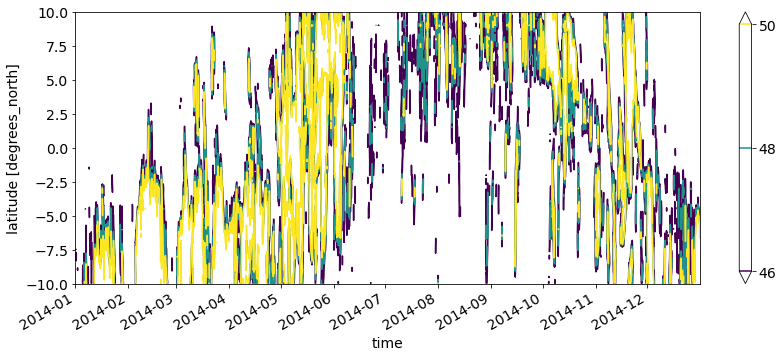

In [100]:
#fig = plt.figure(figsize=(20,5))
#TQV_WEIO.transpose().plot.contour(vmin=46,vmax=50,levels=3, add_colorbar=True)
#plt.title('Latitude-time contours along Africa east coast')

In [116]:
TQV_WEIO.to_netcdf('/data2/brian/WEIO_timelat_2014-8.nc')

In [117]:
TQV_coastal = xr.open_dataset('/data2/brian/WEIO_timelat_2014-8.nc')
TQV_coastal

<xarray.Dataset>
Dimensions:                        (lat: 40, time: 43824)
Coordinates:
  * lat                            (lat) float64 -10.0 -9.5 -9.0 ... 9.5 10.0
  * time                           (time) datetime64[ns] 2014-01-01 ... 2018-...
Data variables:
    __xarray_dataarray_variable__  (time, lat) float32 ...

Text(0.5, 1.0, 'Latitude-time contours along Africa east coast')

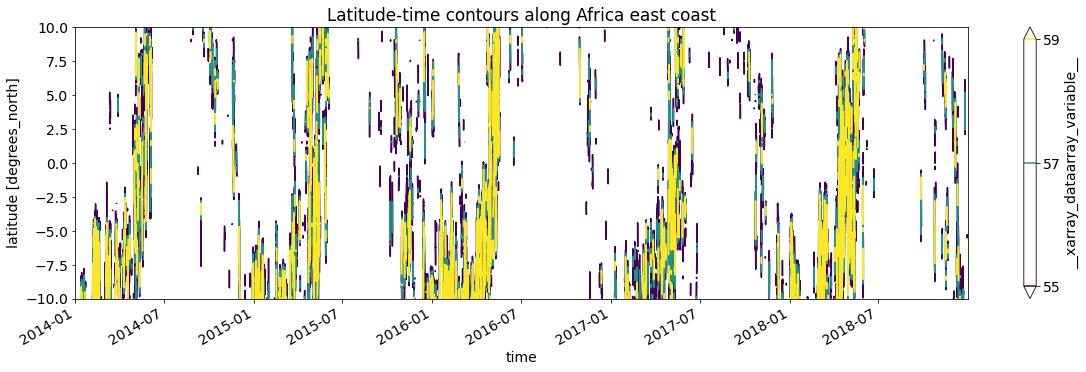

In [118]:
fig = plt.figure(figsize=(20,5))
TQV_coastal.__xarray_dataarray_variable__.transpose().plot.contour(vmin=55,vmax=59,levels=3, add_colorbar=True)
plt.title('Latitude-time contours along Africa east coast')

In [130]:
# Whole WEIO subset out to lon=100, for connected region segmentation. Wish I could resample to 3-hourly, but too hard to look up how. 

WEIO_box = TQV.sel(lon=slice(30,100),lat=slice(-20,20))
WEIO_box


<xarray.DataArray 'TQV' (time: 43824, lat: 81, lon: 113)>
dask.array<getitem, shape=(43824, 81, 113), dtype=float32, chunksize=(24, 81, 113), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Attributes:
    standard_name:   total_precipitable_water_vapor
    long_name:       total_precipitable_water_vapor
    units:           kg m-2
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [131]:
WEIO_box.to_netcdf('/data2/brian/WEIO_30-100_20S-20N_2014-8.nc')

In [132]:
TQV_WEIO = xr.open_dataset('/data2/brian/WEIO_30-100_20S-20N_2014-8.nc')
TQV_WEIO

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 43824)
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    TQV      (time, lat, lon) float32 ...

In [133]:
!ls -atlh /data2/brian/WEIO_30-100_20S-20N_2014-8.nc

-rw-rw-r-- 1 bmapes bmapes 755M Mar 10 18:55 /data2/brian/WEIO_30-100_20S-20N_2014-8.nc
